# In-Processing Mitigation

##  Logistic Regression

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset

2025-05-28 17:12:38.683522: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
pip install 'aif360[inFairness]'


In [5]:
df = pd.read_csv('complete_df_with_predictions.csv')

In [6]:
# Features we want to use
features = ['male', 'decile1', 'decile3', 'lsat', 'ugpa', 'zfygpa', 'zgpa', 'parttime', 'fam_inc', 'tier', 'race1_black', 'race1_hisp', 'race1_other', 'race1_white']

# Target variable
target = 'pass_bar'

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

### Fairness Constrain on fam_inc 

We will first try with **Fairness Constrained** on Logistic Regression, intervening directly on the loss function introducing 
Demographic Parity, Equal Opportunity, Equalized Odds.

In [7]:
mitigator = ExponentiatedGradient(
    # Let's use the same parameters as the best model we previously trained
    LogisticRegression(max_iter=1000, C=1, class_weight={0: 5, 1: 1}),
    constraints=DemographicParity()
)

# Fit model with fairness constraint on fam_income
mitigator.fit(X_train, y_train, sensitive_features=X_train['fam_inc'])

# Predict on test set
y_pred = mitigator.predict(X_test)

In [8]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 176   51]
 [2742 1446]]
              precision    recall  f1-score   support

           0       0.06      0.78      0.11       227
           1       0.97      0.35      0.51      4188

    accuracy                           0.37      4415
   macro avg       0.51      0.56      0.31      4415
weighted avg       0.92      0.37      0.49      4415



In [9]:
pass_bar_lr_weighted_fair_fam_inc = mitigator.predict(df[features])
df['pass_bar_lr_weighted_fair_fam_inc'] = pass_bar_lr_weighted_fair_fam_inc

In [10]:
def get_DI_and_SPD(groups, df, feature_name, ref_val, pred_col):
    
    results = {}
    
    for group in groups:
        df_temp = df[df[feature_name].isin([ref_val, group])].copy()
        df_temp[f"{feature_name}_bin"] = df_temp[feature_name].apply(lambda x: 1 if x == ref_val else 0)
        df_numeric = df_temp.select_dtypes(include=[np.number])
        
        for col in [pred_col, f"{feature_name}_bin"]:
            if col not in df_numeric.columns:
                df_numeric[col] = df_temp[col]

        df_numeric = df_numeric.dropna(subset=[pred_col, f"{feature_name}_bin"])

        dataset = BinaryLabelDataset(
            favorable_label=1,
            unfavorable_label=0,
            df=df_numeric,
            label_names=[pred_col],
            protected_attribute_names=[f"{feature_name}_bin"]
        )

        metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{f"{feature_name}_bin": 1}],  
        unprivileged_groups=[{f"{feature_name}_bin": 0}] 
        )
        
        results[group] = {
        "Disparate Impact": metric.disparate_impact(),
        "Statistical Parity Difference": metric.statistical_parity_difference()
        }
        
    return results
        
        
def plot_DI(results, col_name, refer_class):
    results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': col_name})
    results_df = results_df.sort_values(by=col_name)

    plt.figure(figsize=(10, 5))
    sns.barplot(data=results_df, x=col_name, y='Disparate Impact', palette='crest')
    plt.axhline(1.0, linestyle='--', color='black')
    plt.title(f"Disparate Impact by {col_name} (Compared to {refer_class})")
    plt.ylabel("Disparate Impact")
    plt.xlabel(col_name)

    for idx, row in results_df.iterrows():
        plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

    plt.tight_layout()
    plt.show()

/var/folders/qz/sgmt7pkx6ps6l99d21v6pz1m0000gn/T/ipykernel_1057/3222572137.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x=col_name, y='Disparate Impact', palette='crest')


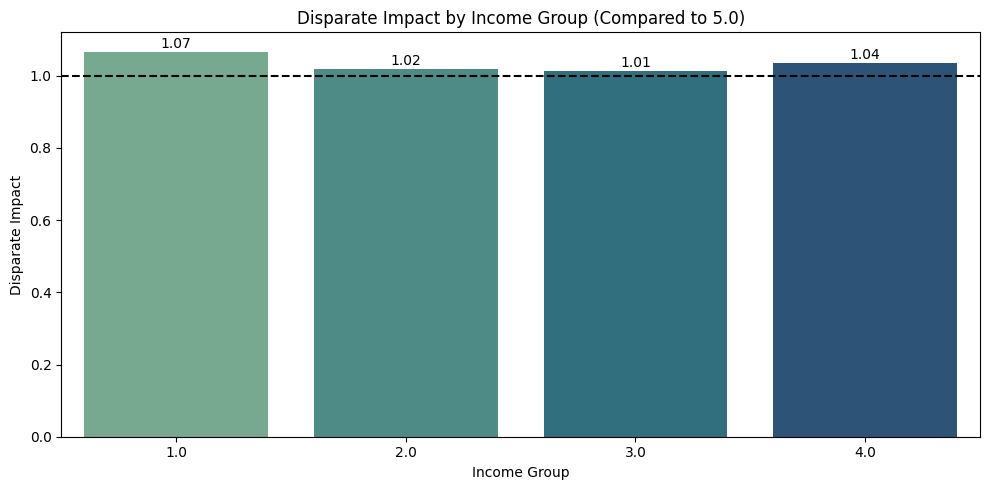

In [11]:
income_groups = [1.0, 2.0, 3.0, 4.0]
results = get_DI_and_SPD(income_groups, df, 'fam_inc', 5.0, 'pass_bar_lr_weighted_fair_fam_inc')
plot_DI(results, 'Income Group', 5.0)

### Fairness Constrain on Tier

In [12]:
mitigator = ExponentiatedGradient(
    LogisticRegression(max_iter=1000, C=1, class_weight={0: 5, 1: 1}),
    constraints=DemographicParity()
)

#mitigator.fit(X_train, y_train, sensitive_features=X_train['tier'])
mitigator.fit(X_train, y_train, sensitive_features=X_train['tier'])
y_pred = mitigator.predict(X_test)

In [13]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  99  128]
 [ 257 3931]]
              precision    recall  f1-score   support

           0       0.28      0.44      0.34       227
           1       0.97      0.94      0.95      4188

    accuracy                           0.91      4415
   macro avg       0.62      0.69      0.65      4415
weighted avg       0.93      0.91      0.92      4415



It seems that forcing parity over the tier feasture introduces some unabalancing in the model. But let's see if the we managed to remove the bias.

In [14]:
pass_bar_lr_weighted_fair_tier = mitigator.predict(df[features])
df['pass_bar_lr_weighted_fair_tier'] = pass_bar_lr_weighted_fair_tier

/var/folders/qz/sgmt7pkx6ps6l99d21v6pz1m0000gn/T/ipykernel_1057/3222572137.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x=col_name, y='Disparate Impact', palette='crest')


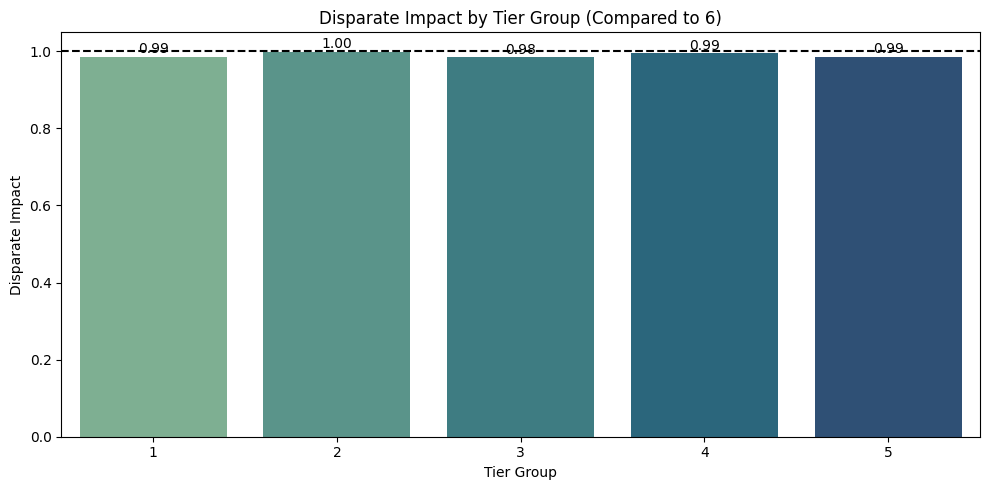

In [15]:
tier_groups = [1, 2, 3, 4, 5]
results = get_DI_and_SPD(tier_groups, df, 'tier', 6, 'pass_bar_lr_weighted_fair_tier')
plot_DI(results, 'Tier Group', 6)

### Fairness Constrain on Race

In [16]:
features_race1 = features.copy()
features_race1.append('race1')
#X_train_race, X_test_race, y_train_race, y_test_race = train_test_split(df[features_race1], df[target], test_size=0.2, random_state=42)

In [17]:
sensitive_race_train = df.loc[X_train.index, 'race1']

In [18]:
mitigator = ExponentiatedGradient(
    LogisticRegression(max_iter=1000, C=1, class_weight={0: 5, 1: 1}),
    constraints=DemographicParity()
)

mitigator.fit(X_train, y_train, sensitive_features=sensitive_race_train)
y_pred = mitigator.predict(X_test)

In [19]:
pass_bar_lr_weighted_fair_race = mitigator.predict(df[features])
df['pass_bar_lr_weighted_fair_race'] = pass_bar_lr_weighted_fair_race

In [20]:
print(df['race1'].unique())

['white' 'hisp' 'asian' 'black' 'other']


/var/folders/qz/sgmt7pkx6ps6l99d21v6pz1m0000gn/T/ipykernel_1057/3222572137.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x=col_name, y='Disparate Impact', palette='crest')


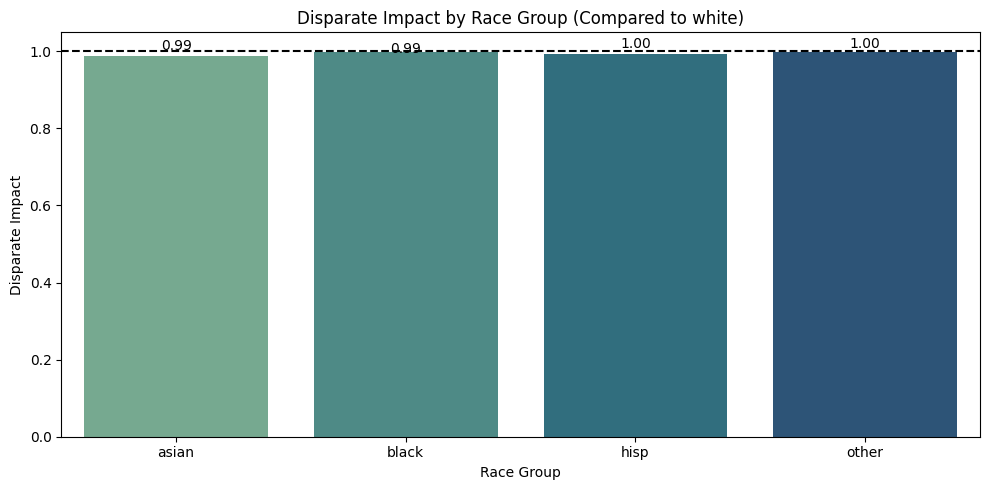

In [21]:
race_groups = ['hisp', 'asian', 'black', 'other']
results = get_DI_and_SPD(race_groups, df, 'race1', 'white', 'pass_bar_lr_weighted_fair_race')
plot_DI(results, 'Race Group', 'white')

## Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

### Fairness Constrain on Family Income

In [23]:
mitigator = ExponentiatedGradient(
    # Let's use the same parameters as the best model we previously trained
    RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced', min_samples_leaf=2, max_depth=8, min_samples_split=10),
    constraints=DemographicParity()
)

# Fit model with fairness constraint on fam_income
mitigator.fit(X_train, y_train, sensitive_features=X_train['fam_inc'])

# Predict on test set
y_pred = mitigator.predict(X_test)

In [24]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 145   82]
 [ 678 3510]]
              precision    recall  f1-score   support

           0       0.18      0.64      0.28       227
           1       0.98      0.84      0.90      4188

    accuracy                           0.83      4415
   macro avg       0.58      0.74      0.59      4415
weighted avg       0.94      0.83      0.87      4415



In [25]:
pass_bar_rf_fair_fam_inc = mitigator.predict(df[features])
df['pass_bar_rf_fair_fam_inc'] = pass_bar_rf_fair_fam_inc

/var/folders/qz/sgmt7pkx6ps6l99d21v6pz1m0000gn/T/ipykernel_1057/3222572137.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x=col_name, y='Disparate Impact', palette='crest')


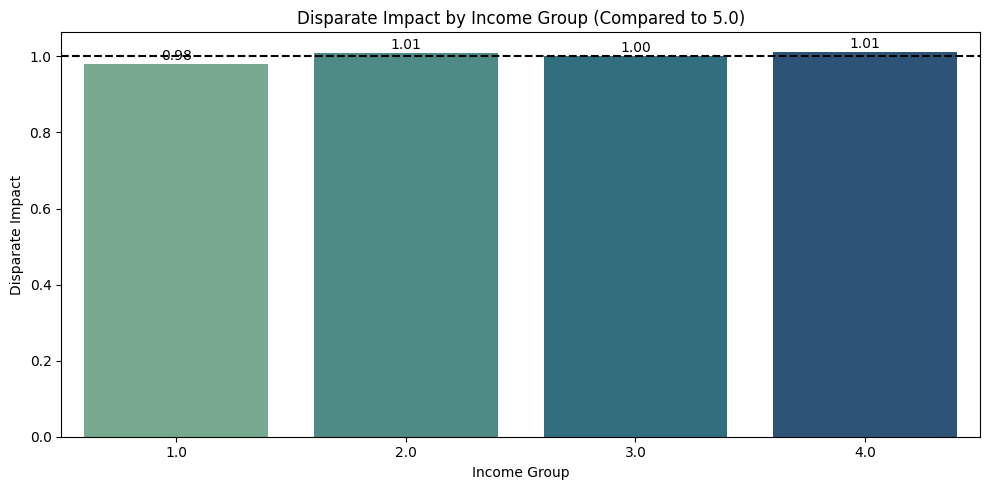

In [26]:
income_groups = [1.0, 2.0, 3.0, 4.0]
results = get_DI_and_SPD(income_groups, df, 'fam_inc', 5.0, 'pass_bar_rf_fair_fam_inc')
plot_DI(results, 'Income Group', 5.0)

### Fairness Constrain on Tier

In [27]:
mitigator = ExponentiatedGradient(
    RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced', min_samples_leaf=2, max_depth=8, min_samples_split=10),
    constraints=DemographicParity()
)

#mitigator.fit(X_train, y_train, sensitive_features=X_train['tier'])
mitigator.fit(X_train, y_train, sensitive_features=X_train['tier'])
y_pred = mitigator.predict(X_test)

In [28]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 143   84]
 [ 643 3545]]
              precision    recall  f1-score   support

           0       0.18      0.63      0.28       227
           1       0.98      0.85      0.91      4188

    accuracy                           0.84      4415
   macro avg       0.58      0.74      0.59      4415
weighted avg       0.94      0.84      0.87      4415



In [29]:
pass_bar_rf_fair_tier = mitigator.predict(df[features])
df['pass_bar_rf_fair_tier'] = pass_bar_rf_fair_tier

/var/folders/qz/sgmt7pkx6ps6l99d21v6pz1m0000gn/T/ipykernel_1057/3222572137.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x=col_name, y='Disparate Impact', palette='crest')


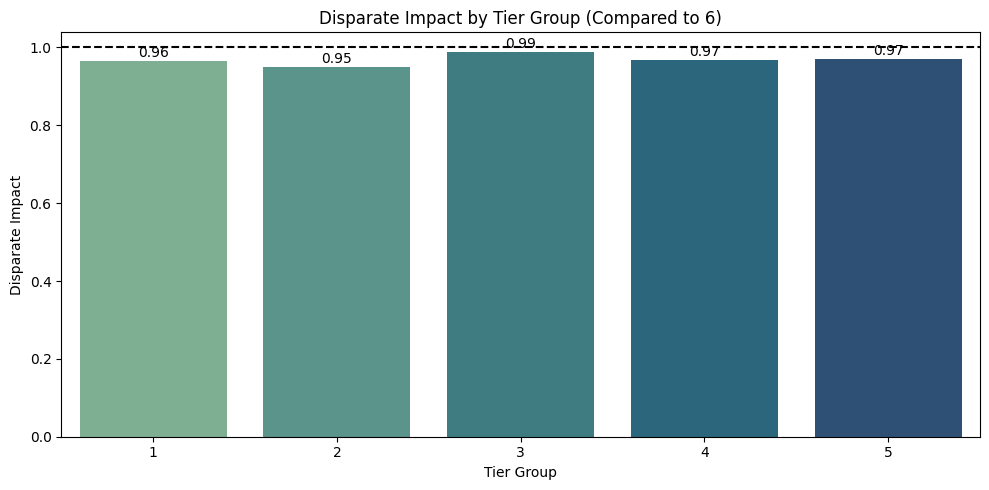

In [30]:
tier_groups = [1, 2, 3, 4, 5]
results = get_DI_and_SPD(tier_groups, df, 'tier', 6, 'pass_bar_rf_fair_tier')
plot_DI(results, 'Tier Group', 6)

### Fairness Constrain on Race

In [31]:
mitigator = ExponentiatedGradient(
    RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced', min_samples_leaf=2, max_depth=8, min_samples_split=10),
    constraints=DemographicParity()
)

mitigator.fit(X_train, y_train, sensitive_features=sensitive_race_train)
y_pred = mitigator.predict(X_test)

In [32]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  70  157]
 [ 551 3637]]
              precision    recall  f1-score   support

           0       0.11      0.31      0.17       227
           1       0.96      0.87      0.91      4188

    accuracy                           0.84      4415
   macro avg       0.54      0.59      0.54      4415
weighted avg       0.92      0.84      0.87      4415



In [33]:
pass_bar_rf_fair_race = mitigator.predict(df[features])
df['pass_bar_rf_fair_race'] = pass_bar_rf_fair_race

/var/folders/qz/sgmt7pkx6ps6l99d21v6pz1m0000gn/T/ipykernel_1057/3222572137.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x=col_name, y='Disparate Impact', palette='crest')


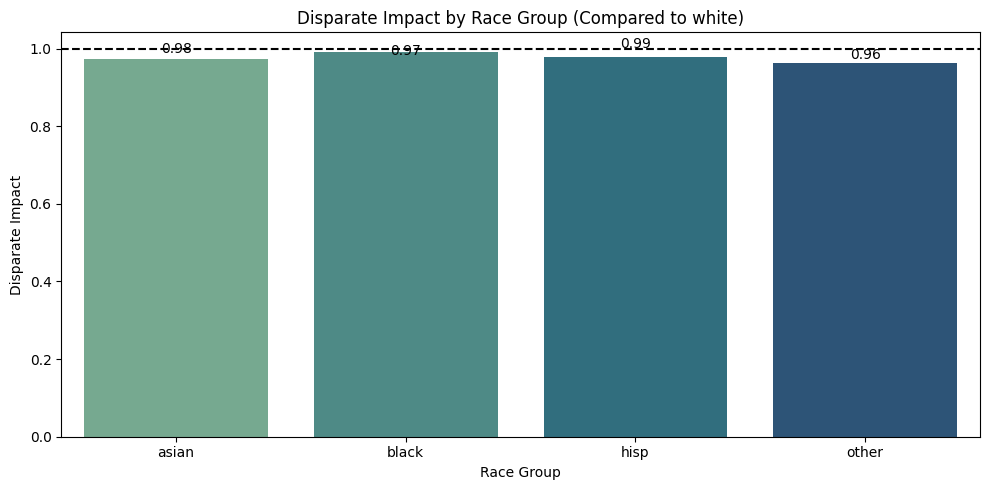

In [34]:
results = get_DI_and_SPD(race_groups, df, 'race1', 'white', 'pass_bar_rf_fair_race')
plot_DI(results, 'Race Group', 'white')

##  XGBoost

In [35]:
from xgboost import XGBClassifier

ratio = np.sum(y_train == 0) / np.sum(y_train == 1)

### Fairness Constraint on fam_inc

In [36]:
mitigator = ExponentiatedGradient(
    # Let's use the same parameters as the best model we previously trained
    XGBClassifier(eval_metric='logloss', scale_pos_weight=ratio, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200),
    constraints=DemographicParity()
)

# Fit model with fairness constraint on fam_income
mitigator.fit(X_train, y_train, sensitive_features=X_train['fam_inc'])

# Predict on test set
y_pred = mitigator.predict(X_test)

In [37]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 161   66]
 [ 696 3492]]
              precision    recall  f1-score   support

           0       0.19      0.71      0.30       227
           1       0.98      0.83      0.90      4188

    accuracy                           0.83      4415
   macro avg       0.58      0.77      0.60      4415
weighted avg       0.94      0.83      0.87      4415



In [38]:
pass_bar_xgb_fair_fam_inc = mitigator.predict(df[features])
df['pass_bar_xgb_fair_fam_inc'] = pass_bar_xgb_fair_fam_inc

/var/folders/qz/sgmt7pkx6ps6l99d21v6pz1m0000gn/T/ipykernel_1057/3222572137.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x=col_name, y='Disparate Impact', palette='crest')


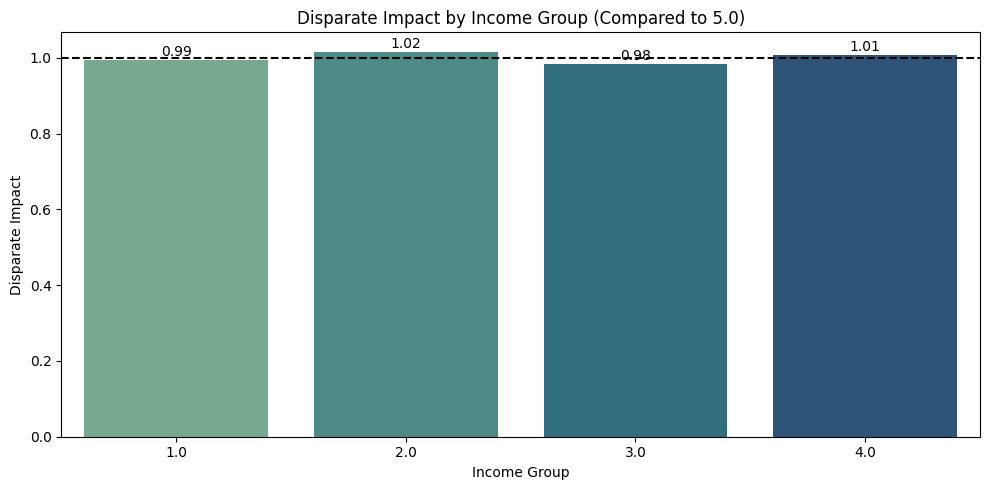

In [39]:
results = get_DI_and_SPD(income_groups, df, 'fam_inc', 5.0, 'pass_bar_xgb_fair_fam_inc')
plot_DI(results, 'Income Group', 5.0)

### Fairness Constraint on Tier

In [40]:
mitigator = ExponentiatedGradient(
    # Let's use the same parameters as the best model we previously trained
    XGBClassifier(eval_metric='logloss', scale_pos_weight=ratio, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200),
    constraints=DemographicParity()
)

# Fit model with fairness constraint on fam_income
mitigator.fit(X_train, y_train, sensitive_features=X_train['tier'])

# Predict on test set
y_pred = mitigator.predict(X_test)

In [41]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 153   74]
 [ 687 3501]]
              precision    recall  f1-score   support

           0       0.18      0.67      0.29       227
           1       0.98      0.84      0.90      4188

    accuracy                           0.83      4415
   macro avg       0.58      0.75      0.59      4415
weighted avg       0.94      0.83      0.87      4415



In [43]:
pass_bar_xgb_fair_tier = mitigator.predict(df[features])
df['pass_bar_xgb_fair_tier'] = pass_bar_xgb_fair_tier

/var/folders/qz/sgmt7pkx6ps6l99d21v6pz1m0000gn/T/ipykernel_1057/3222572137.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x=col_name, y='Disparate Impact', palette='crest')


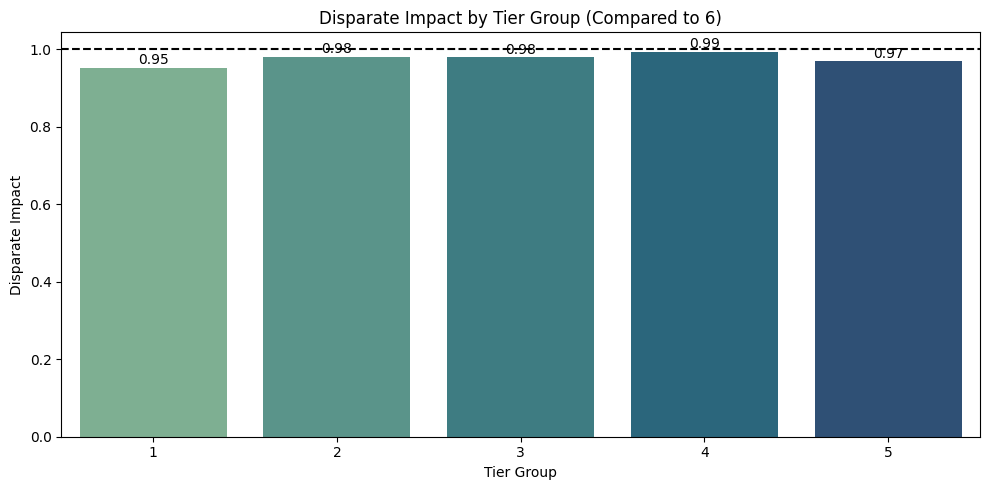

In [44]:
tier_groups = [1, 2, 3, 4, 5]
results = get_DI_and_SPD(tier_groups, df, 'tier', 6, 'pass_bar_xgb_fair_tier')
plot_DI(results, 'Tier Group', 6)

### Fairness Constraint on Race

In [45]:
mitigator = ExponentiatedGradient(
    XGBClassifier(eval_metric='logloss', scale_pos_weight=ratio, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200),
    constraints=DemographicParity()
)

mitigator.fit(X_train, y_train, sensitive_features=sensitive_race_train)
y_pred = mitigator.predict(X_test)

In [46]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  67  160]
 [ 449 3739]]
              precision    recall  f1-score   support

           0       0.13      0.30      0.18       227
           1       0.96      0.89      0.92      4188

    accuracy                           0.86      4415
   macro avg       0.54      0.59      0.55      4415
weighted avg       0.92      0.86      0.89      4415



In [47]:
pass_bar_xgb_fair_race = mitigator.predict(df[features])
df['pass_bar_xgb_fair_race'] = pass_bar_xgb_fair_race

/var/folders/qz/sgmt7pkx6ps6l99d21v6pz1m0000gn/T/ipykernel_1057/3222572137.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x=col_name, y='Disparate Impact', palette='crest')


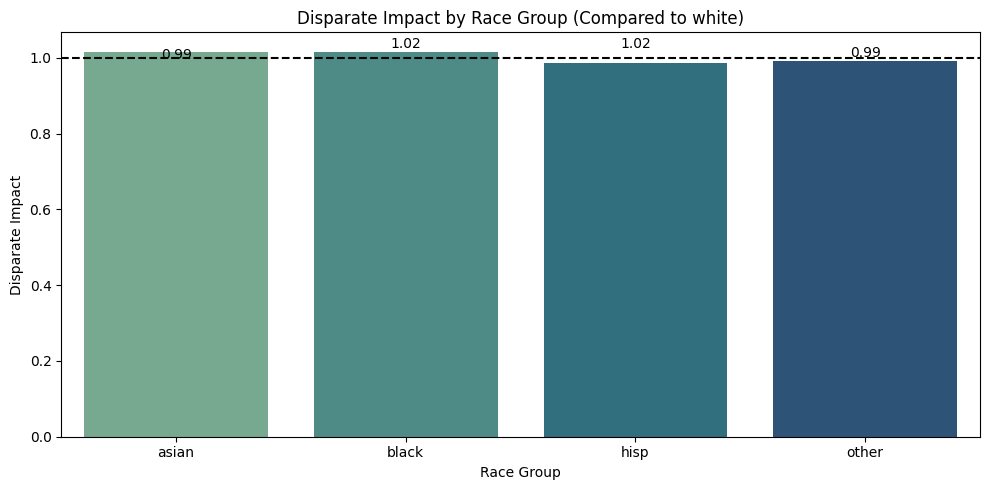

In [48]:
results = get_DI_and_SPD(race_groups, df, 'race1', 'white', 'pass_bar_xgb_fair_race')
plot_DI(results, 'Race Group', 'white')